# Audit trails for graph objects in ReGraph (aka versioning)

ReGraph implements a framework for the version control (VC) of graph transformations

The data structure `VersionedGraph` allows to store the history of transformations of a graph object and perform the following VC operations:

- _Rewrite_: perform a rewriting of the object with a commit to the revision history
- _Branch_: create a new branch (with a diverged version of the graph object)
- _Merge branches_: merge branches
- _Rollback_: rollback to a point in the history of transformations

In [1]:
from regraph import NXGraph
from regraph.audit import VersionedGraph
from regraph.rules import Rule
from regraph import print_graph, plot_rule, plot_graph

Create a graph and pass it to the `VersionedGraph` wrapper that will take care of the version control.

In [2]:
graph_obj = NXGraph()
g = VersionedGraph(graph_obj)

Now let's create a rule that adds to the graph two nodes connected with an edge and apply it. If we want the changes to be commited to the version control we rewrite through the `rewrite` method of a `VersioneGraph` object.

/home/raimon/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/raimon/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


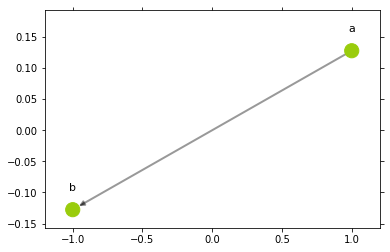

{'a': array([1.        , 0.12769283]), 'b': array([-1.        , -0.12769283])}

In [3]:
rule = Rule.from_transform(NXGraph())
rule.inject_add_node("a")
rule.inject_add_node("b")
rule.inject_add_edge("a", "b")

rhs_instance, _ = g.rewrite(rule, {}, message="Add a -> b")
plot_graph(g.graph)

We create a new branch called "branch"

In [4]:
branch_commit = g.branch("branch")

In [5]:
print("Branches: ", g.branches())
print("Current branch '{}'".format(g.current_branch()))

Branches:  ['master', 'branch']
Current branch 'branch'


Apply a rule that clones the node 'b' to the current vesion of the graph (branch 'branch')

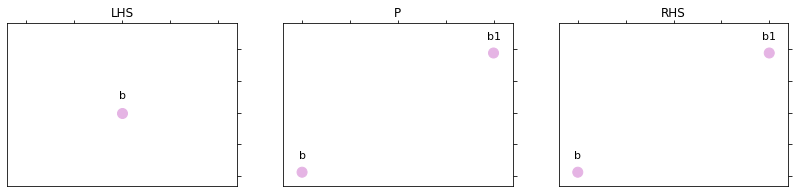

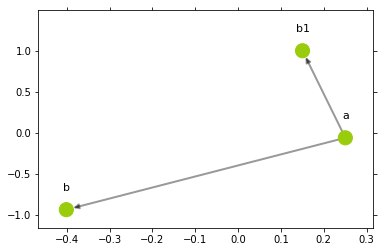

{'a': array([ 0.25050521, -0.06178004]),
 'b': array([-0.40100886, -0.93821996]),
 'b1': array([0.15050365, 1.        ])}

In [6]:
pattern = NXGraph()
pattern.add_node("b")
rule = Rule.from_transform(pattern)
rule.inject_clone_node("b")
plot_rule(rule)

rhs_instance, commit_id = g.rewrite(rule, {"b": rhs_instance["b"]}, message="Clone b")
plot_graph(g.graph)

The `rewrite` method of `VersionedGraph` returns the RHS instance of the applied and the id of the newly created commit corresponding to this rewrite.

In [7]:
print("RHS instance", rhs_instance)
print("Commit ID: ", commit_id)

RHS instance {'b': 'b1', 'b1': 'b'}
Commit ID:  e916119f-61d5-4e38-ba6f-9eb921f16a46


Switch back to the 'master' branch

In [8]:
g.switch_branch("master")
print(g.current_branch())

master


Apply a rule that adds a loop form 'a' to itself, a new node 'c' and connects it with 'a'

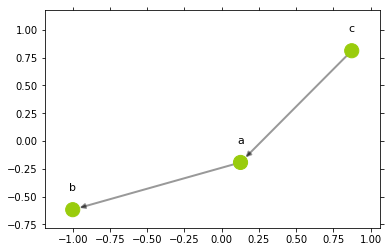

{'a': array([ 0.12668879, -0.19332068]),
 'b': array([-1.        , -0.61842372]),
 'c': array([0.87331121, 0.8117444 ])}

In [9]:
pattern = NXGraph()
pattern.add_node("a")
rule = Rule.from_transform(pattern)
rule.inject_add_node("c")
rule.inject_add_edge("c", "a")
rule.inject_add_edge("a", "a")

rhs_instance, _ = g.rewrite(rule, {"a": "a"}, message="Add c and c->a")
plot_graph(g.graph)

Create a new branch 'dev'

In [10]:
g.branch("dev")

'718d78fe-e39c-4fa8-9ec2-6e16c9f72a70'

In this branch remove an edge from 'c' to 'a' and merge two nodes together

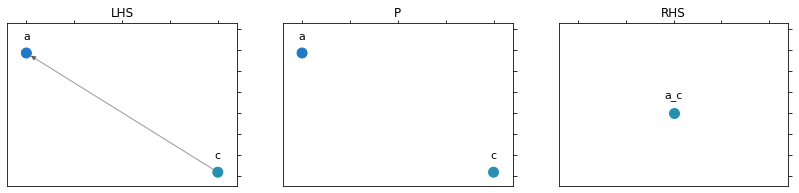

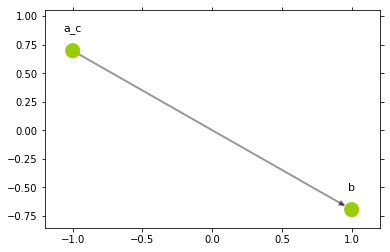

{'b': array([ 1.       , -0.6968324]), 'a_c': array([-1.       ,  0.6968324])}

In [11]:
pattern = NXGraph()
pattern.add_node("c")
pattern.add_node("a")
pattern.add_edge("c", "a")
rule = Rule.from_transform(pattern)
rule.inject_remove_edge("c", "a")
rule.inject_merge_nodes(["c", "a"])
plot_rule(rule)

g.rewrite(rule, {"a": rhs_instance["a"], "c": rhs_instance["c"]}, message="Merge c and a")
plot_graph(g.graph)

Switch back to the 'master' branch.

In [12]:
g.switch_branch("master")

Apply a rule that clones a node 'a'

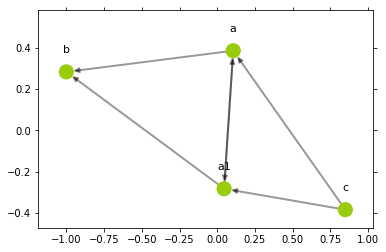

{'b': array([-1.        ,  0.28258431]),
 'c': array([ 0.84888266, -0.38447044]),
 'a': array([0.10569474, 0.38496972]),
 'a1': array([ 0.04542259, -0.28308359])}

In [13]:
pattern = NXGraph()
pattern.add_node("a")
rule = Rule.from_transform(pattern)
_, rhs_clone = rule.inject_clone_node("a")
rhs_instance, rollback_commit = g.rewrite(rule, {"a": rhs_instance["a"]}, message="Clone a")
plot_graph(g.graph)

Create a new branch 'test'

In [14]:
g.branch("test")

'fc2b3516-b31f-4bf0-ad52-533813781d3f'

In this branch apply the rule that adds a new node 'd' and connects it with an edge to one of the cloned 'a' nodes

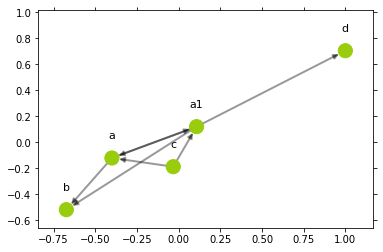

{'b': array([-0.67410961, -0.51722017]),
 'c': array([-0.03253862, -0.18702102]),
 'a': array([-0.4006808 , -0.12011358]),
 'a1': array([0.10732903, 0.12056189]),
 'd': array([1.        , 0.70379289])}

In [15]:
pattern = NXGraph()
pattern.add_node("a")
rule = Rule.from_transform(pattern)
rule.inject_add_node("d")
rule.inject_add_edge("a", "d")
g.rewrite(rule, {"a": rhs_instance[rhs_clone]}, message="Add d -> clone of a")
plot_graph(g.graph)

Switch back to 'master'

In [16]:
g.switch_branch("master")

Remove a node 'a'

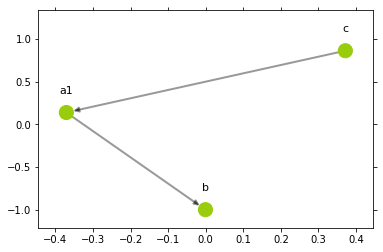

{'b': array([-6.73394186e-04, -1.00000000e+00]),
 'c': array([0.37144577, 0.86176356]),
 'a1': array([-0.37077238,  0.13823644])}

In [17]:
pattern = NXGraph()
pattern.add_node("a")
rule = Rule.from_transform(pattern)
rule.inject_remove_node("a")
rhs_instance, _ = g.rewrite(rule, {"a": rhs_instance["a"]}, message="Remove a")
plot_graph(g.graph)

Merge the branch 'dev' into 'master'

In [18]:
g.merge_with("dev")

'309a5f73-aa58-4d11-845d-4efacd87679c'

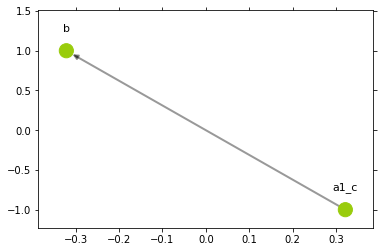

{'b': array([-0.32108623,  1.        ]),
 'a1_c': array([ 0.32108623, -1.        ])}

In [19]:
plot_graph(g.graph)

Merge 'test' into 'master'

In [20]:
g.merge_with("test")

'3d6dfa53-8edb-4602-b6c3-46349534d800'

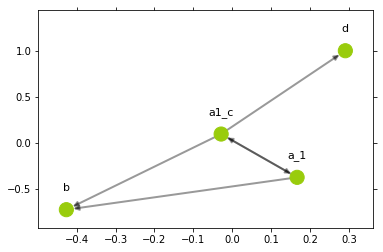

{'b': array([-0.42604917, -0.72368097]),
 'a1_c': array([-0.02907932,  0.09656937]),
 'd': array([0.28941266, 1.        ]),
 'a_1': array([ 0.16571582, -0.3728884 ])}

In [21]:
plot_graph(g.graph)

We can inspect the version control object in more details and look at its attribute `_revision_graph`, whose nodes represent the commits and whose edges represent graph deltas between different commits (basically, rewriting rules that constitute commits). Here we can see that on the nodes of the revision graph are stored branch names to which commits belong and user specified commit messages.

In [22]:
for n, attrs in g._revision_graph.nodes(data=True):
    print("Node ID: ", n)
    print("Attributes: ")
    print("\t", attrs)

Node ID:  d87f0d16-155b-4854-bfe9-f6bfcdb7f946
Attributes: 
	 {'branch': 'master', 'message': 'Initial commit', 'time': datetime.datetime(2020, 3, 30, 20, 57, 52, 620015)}
Node ID:  5ced4ea5-a107-42de-a58d-eb635dfa92b3
Attributes: 
	 {'branch': 'master', 'time': datetime.datetime(2020, 3, 30, 20, 57, 52, 633859), 'message': 'Add a -> b'}
Node ID:  0f1cbd2a-0de8-425f-964d-dbdf5d2e70bc
Attributes: 
	 {'branch': 'branch', 'time': datetime.datetime(2020, 3, 30, 20, 57, 52, 830309), 'message': "Created branch 'branch'"}
Node ID:  e916119f-61d5-4e38-ba6f-9eb921f16a46
Attributes: 
	 {'branch': 'branch', 'time': datetime.datetime(2020, 3, 30, 20, 57, 53, 438862), 'message': 'Clone b'}
Node ID:  6d0e2417-b8c5-4289-bc00-a87904ef945f
Attributes: 
	 {'branch': 'master', 'time': datetime.datetime(2020, 3, 30, 20, 57, 53, 648498), 'message': 'Add c and c->a'}
Node ID:  718d78fe-e39c-4fa8-9ec2-6e16c9f72a70
Attributes: 
	 {'branch': 'dev', 'time': datetime.datetime(2020, 3, 30, 20, 57, 53, 830322), 'm

In [23]:
# Pretty-print the history
g.print_history()

2020-03-30 20:57:52.620015 d87f0d16-155b-4854-bfe9-f6bfcdb7f946 master Initial commit
2020-03-30 20:57:52.633859 5ced4ea5-a107-42de-a58d-eb635dfa92b3 master Add a -> b
2020-03-30 20:57:52.830309 0f1cbd2a-0de8-425f-964d-dbdf5d2e70bc branch Created branch 'branch'
2020-03-30 20:57:53.438862 e916119f-61d5-4e38-ba6f-9eb921f16a46 branch Clone b
2020-03-30 20:57:53.648498 6d0e2417-b8c5-4289-bc00-a87904ef945f master Add c and c->a
2020-03-30 20:57:53.830322 718d78fe-e39c-4fa8-9ec2-6e16c9f72a70 dev Created branch 'dev'
2020-03-30 20:57:54.789783 85c8360e-29c3-4e4d-afdd-f1ca523bc75b dev Merge c and a
2020-03-30 20:57:55.105118 274f1558-a12c-4448-9fd2-7d63f4772a40 master Clone a
2020-03-30 20:57:55.467808 fc2b3516-b31f-4bf0-ad52-533813781d3f test Created branch 'test'
2020-03-30 20:57:55.482334 c889ccbe-172d-4579-b02c-15a64b129e2d test Add d -> clone of a
2020-03-30 20:57:55.738230 327527a7-e926-4624-bbbf-c3016795c7c2 master Remove a
2020-03-30 20:57:55.945093 309a5f73-aa58-4d11-845d-4efacd87679

Now we can rollback to some previous commit (commit where we first cloned the node 'a')

In [24]:
g.rollback(rollback_commit)

Created the new head for 'dev'
Created the new head for 'master'


Branches:  ['master', 'branch', 'dev']
Current branch 'master'
Updated revision graph:
2020-03-30 20:57:52.620015 d87f0d16-155b-4854-bfe9-f6bfcdb7f946 master Initial commit
2020-03-30 20:57:52.633859 5ced4ea5-a107-42de-a58d-eb635dfa92b3 master Add a -> b
2020-03-30 20:57:52.830309 0f1cbd2a-0de8-425f-964d-dbdf5d2e70bc branch Created branch 'branch'
2020-03-30 20:57:53.438862 e916119f-61d5-4e38-ba6f-9eb921f16a46 branch Clone b
2020-03-30 20:57:53.648498 6d0e2417-b8c5-4289-bc00-a87904ef945f master Add c and c->a
2020-03-30 20:57:53.830322 718d78fe-e39c-4fa8-9ec2-6e16c9f72a70 dev Created branch 'dev'
2020-03-30 20:57:54.789783 85c8360e-29c3-4e4d-afdd-f1ca523bc75b dev Merge c and a
2020-03-30 20:57:55.105118 274f1558-a12c-4448-9fd2-7d63f4772a40 master Clone a
Current graph object


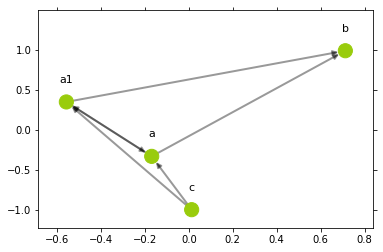


Nodes:

b  :  {}
a1  :  {}
a  :  {}
c  :  {}

Edges:

a1 -> b  :  {}
a1 -> a1  :  {}
a1 -> a  :  {}
a -> a1  :  {}
a -> b  :  {}
a -> a  :  {}
c -> a1  :  {}
c -> a  :  {}


In [25]:
print("Branches: ", g.branches())
print("Current branch '{}'".format(g.current_branch()))
print("Updated revision graph:")
g.print_history()
print("Current graph object")
plot_graph(g.graph)
print_graph(g.graph)

In [26]:
g.switch_branch("branch")

In [27]:
g.rollback(branch_commit)

Created the new head for 'branch'


In [28]:
g.print_history()

2020-03-30 20:57:52.620015 d87f0d16-155b-4854-bfe9-f6bfcdb7f946 master Initial commit
2020-03-30 20:57:52.633859 5ced4ea5-a107-42de-a58d-eb635dfa92b3 master Add a -> b
2020-03-30 20:57:52.830309 0f1cbd2a-0de8-425f-964d-dbdf5d2e70bc branch Created branch 'branch'
2020-03-30 20:57:53.648498 6d0e2417-b8c5-4289-bc00-a87904ef945f master Add c and c->a
2020-03-30 20:57:53.830322 718d78fe-e39c-4fa8-9ec2-6e16c9f72a70 dev Created branch 'dev'
2020-03-30 20:57:54.789783 85c8360e-29c3-4e4d-afdd-f1ca523bc75b dev Merge c and a
2020-03-30 20:57:55.105118 274f1558-a12c-4448-9fd2-7d63f4772a40 master Clone a


{'master': '274f1558-a12c-4448-9fd2-7d63f4772a40', 'branch': '0f1cbd2a-0de8-425f-964d-dbdf5d2e70bc', 'dev': '85c8360e-29c3-4e4d-afdd-f1ca523bc75b'}


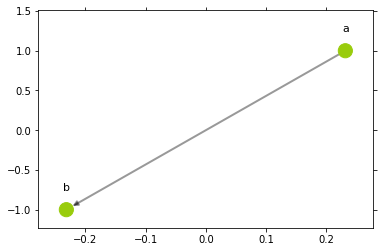

{'a': array([0.23148329, 1.        ]), 'b': array([-0.23148329, -1.        ])}

In [29]:
print(g._heads)
plot_graph(g.graph)

In [30]:
g.switch_branch("master")

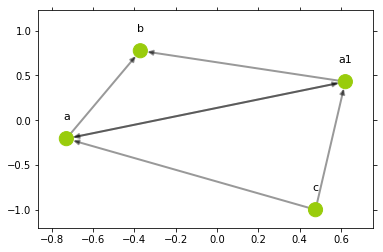

{'a': array([-0.72829653, -0.20635592]),
 'b': array([-0.37039546,  0.77598258]),
 'a1': array([0.62157182, 0.43037333]),
 'c': array([ 0.47712017, -1.        ])}

In [31]:
plot_graph(g.graph)

In [32]:
g.merge_with("branch")

'993bcf3d-00d5-48a2-ad66-bddb4529a278'

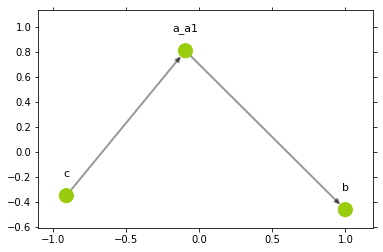

{'b': array([ 1.        , -0.46067039]),
 'c': array([-0.90693215, -0.3488259 ]),
 'a_a1': array([-0.09306785,  0.80949629])}

In [33]:
plot_graph(g.graph)